# TEST 1:

In [1]:
# Add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../")

In [2]:
# import other internal modules and functions
from simulator.swing_equation import swing_equation

# import other external modules and functions
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import BoxUniform, posterior_nn
import torch
import os
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew

c:\Users\basti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the experimental setup variables
num_simulations = [100, 1000, 10000, 25000, 50000, 100000]

# Define the prior distribution for the parameters
prior = BoxUniform(
    low=torch.tensor([0.1, 1.0, 0.1, 40.0, 0.1]),
    high=torch.tensor([10.0, 100.0, 10.0, 70.0, 10.0])
)

# Define the true parameters for training and evaluation
true_parameters = torch.tensor([4.0, 40.0, 3.0, 60.0, 7.0])

# Simulate the observation
observation = swing_equation(true_parameters)

# Wrap the simulator function for compatibility with SBI
simulator, prior = prepare_for_sbi(swing_equation, prior)

posteriors = []

for num in num_simulations:

    # Instantiate the neural density estimator
    neural_posterior = posterior_nn(
        model="maf", hidden_features=10, num_transforms=2
    )

    # Set up the inference procedure with the SNPE-C procedure
    inference = SNPE(prior=prior, density_estimator=neural_posterior)

    # Run the inference procedure to generate samples and corresponding simulated data points
    theta, x = simulate_for_sbi(simulator, prior, num_simulations=num)

    # train the neural density estimator
    density_estimator = inference.append_simulations(theta, x).train()

    # build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator)
    posterior.set_default_x(observation)

    posteriors.append(posterior)

Running 100 simulations.: 100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


 Neural network successfully converged after 506 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:50<00:00, 19.81it/s]


 Neural network successfully converged after 119 epochs.

Running 10000 simulations.: 100%|██████████| 10000/10000 [08:15<00:00, 20.16it/s]


 Neural network successfully converged after 188 epochs.

Running 25000 simulations.: 100%|██████████| 25000/25000 [20:36<00:00, 20.22it/s]


 Neural network successfully converged after 140 epochs.

Running 50000 simulations.: 100%|██████████| 50000/50000 [45:39<00:00, 18.25it/s]    


 Neural network successfully converged after 148 epochs.

Running 100000 simulations.: 100%|██████████| 100000/100000 [3:00:28<00:00,  9.23it/s]     


 Neural network successfully converged after 125 epochs.

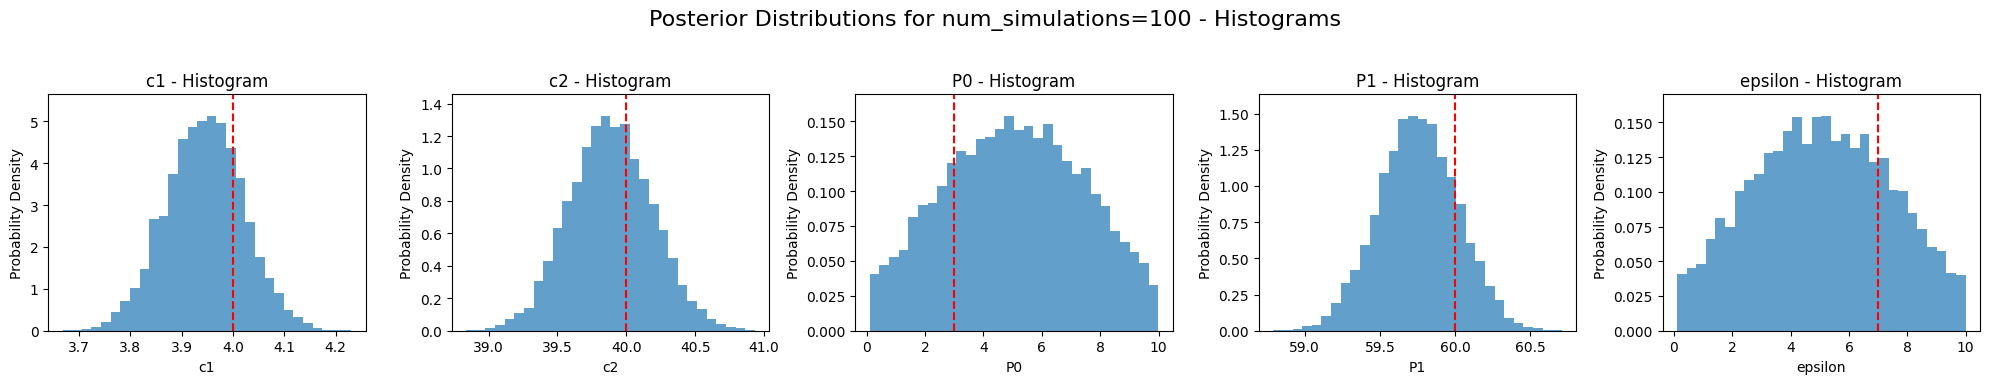

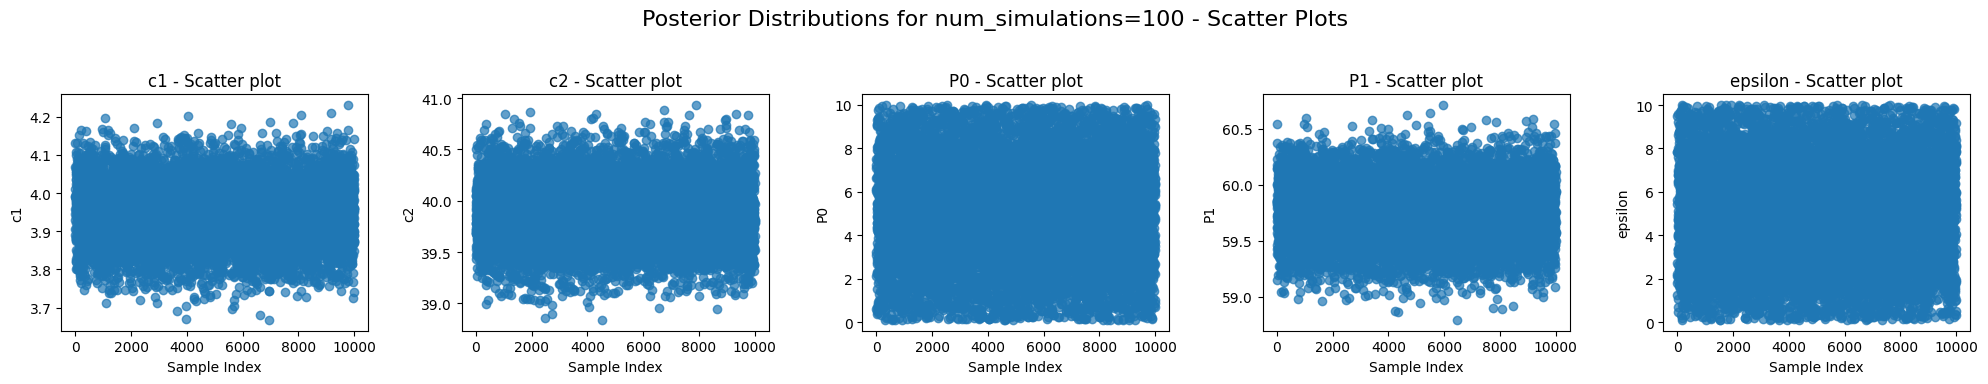

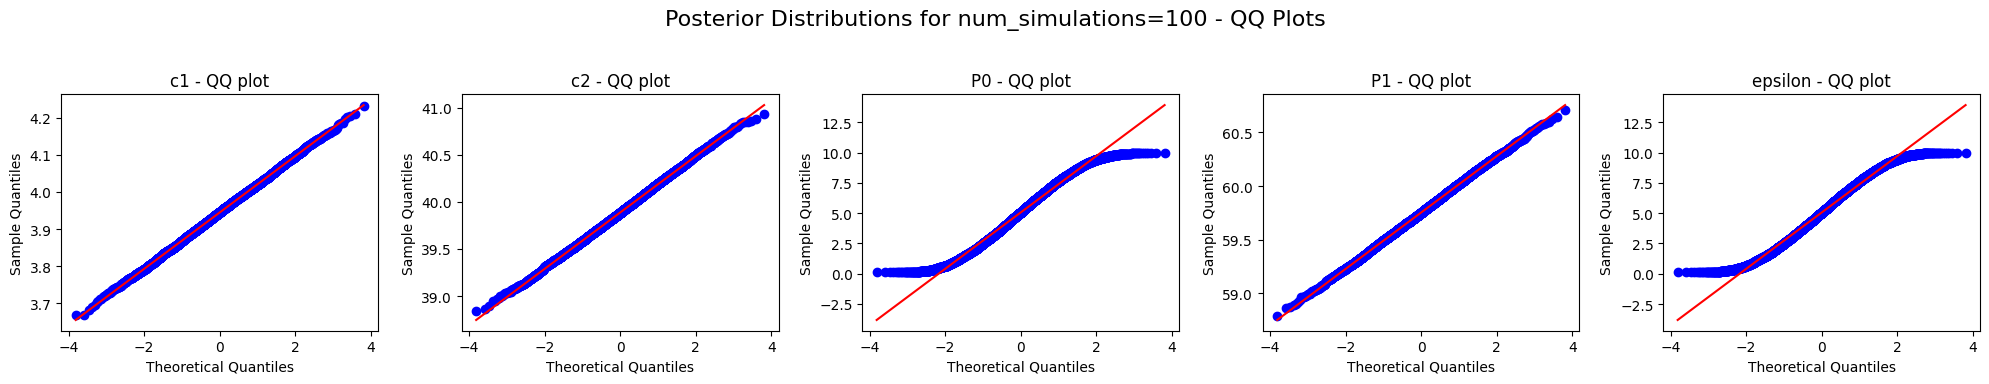

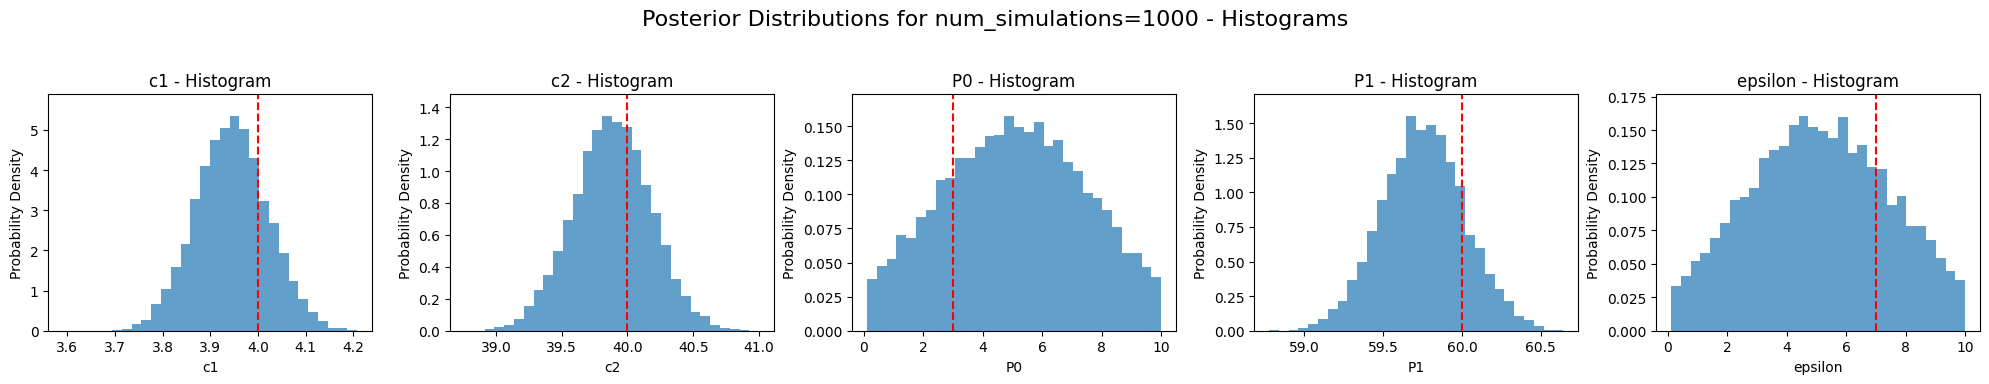

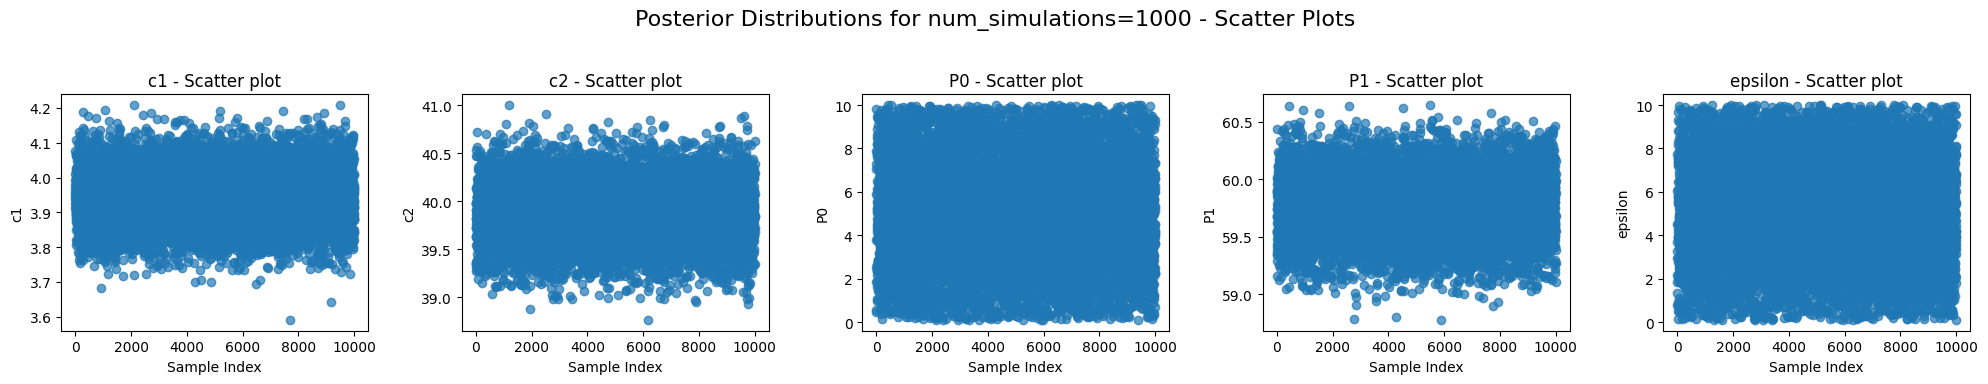

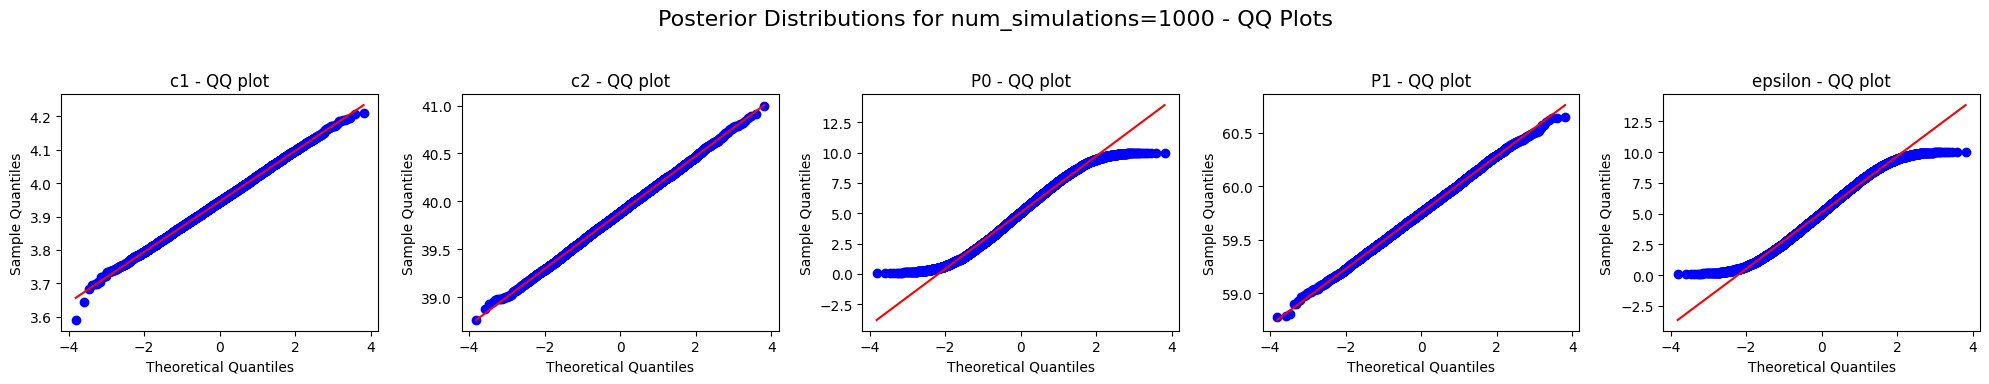

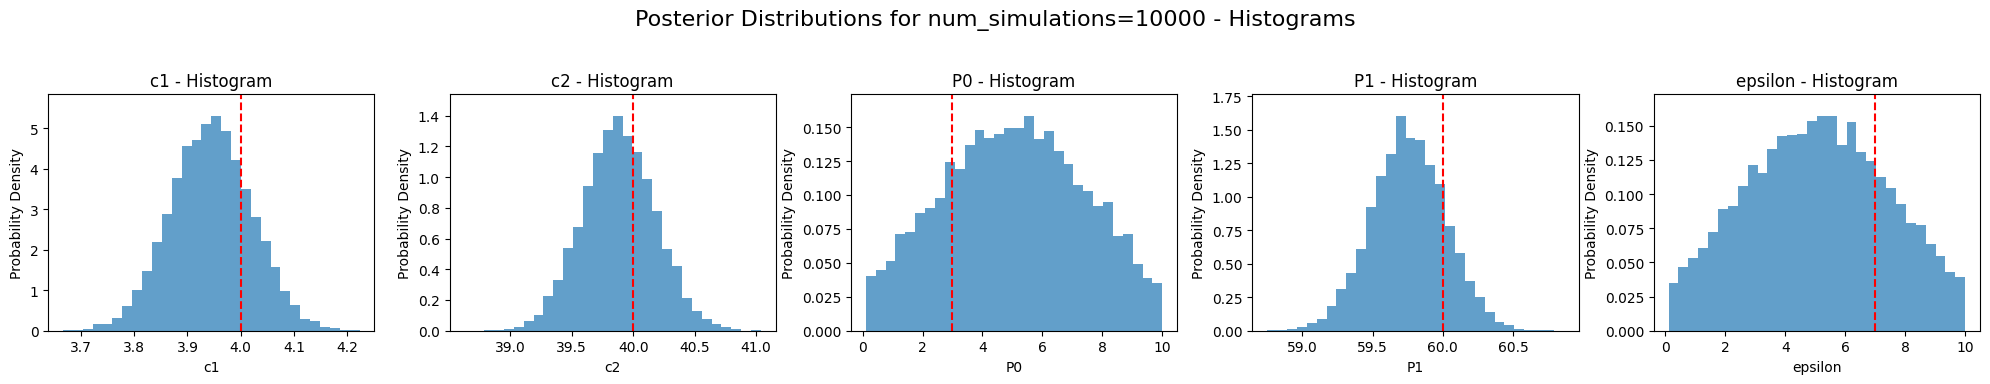

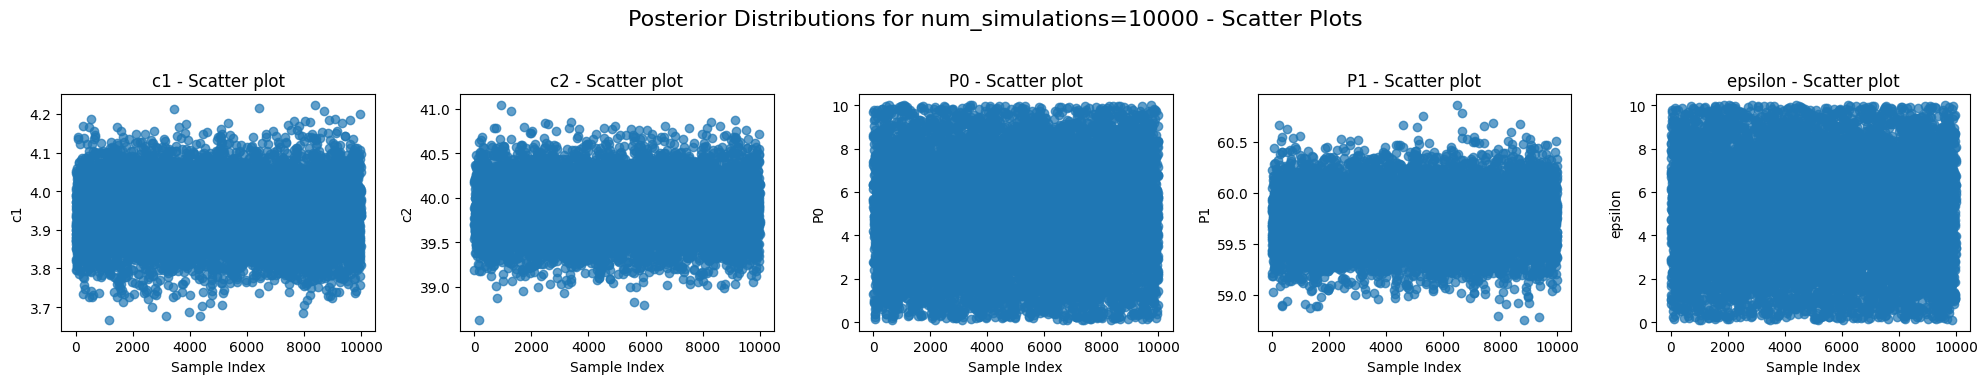

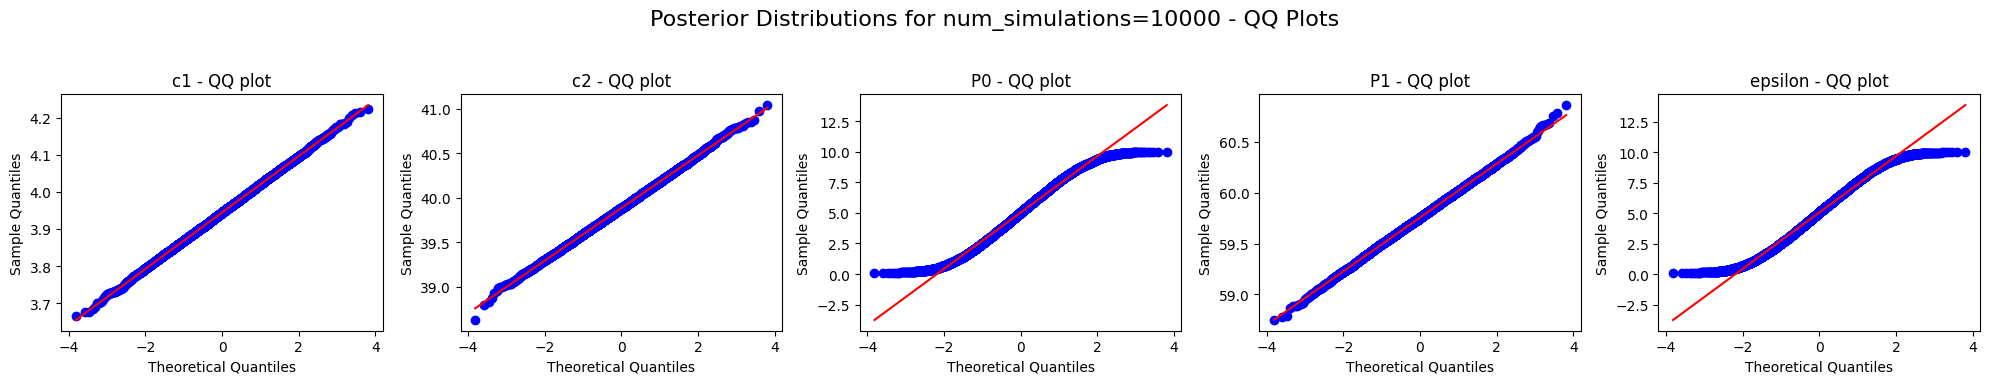

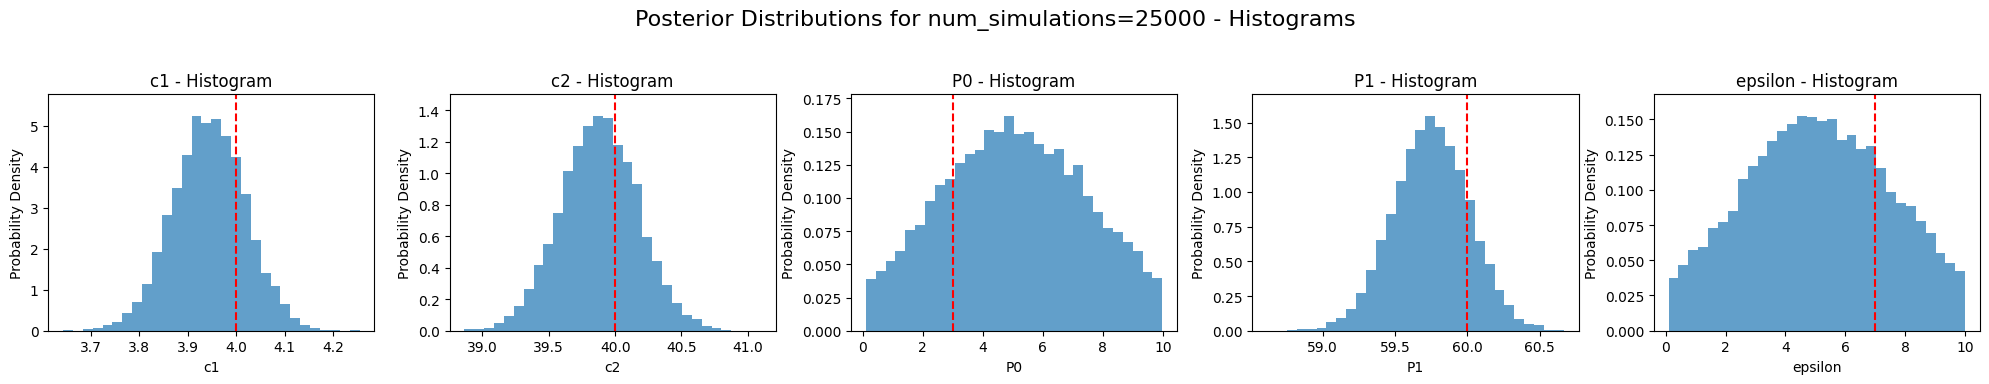

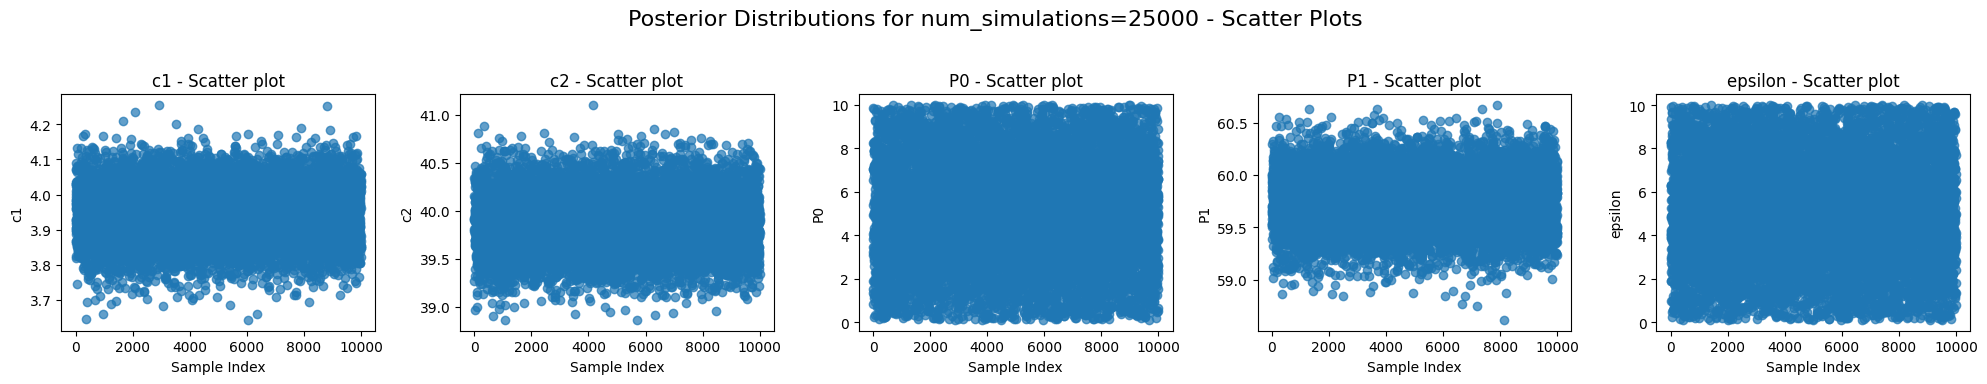

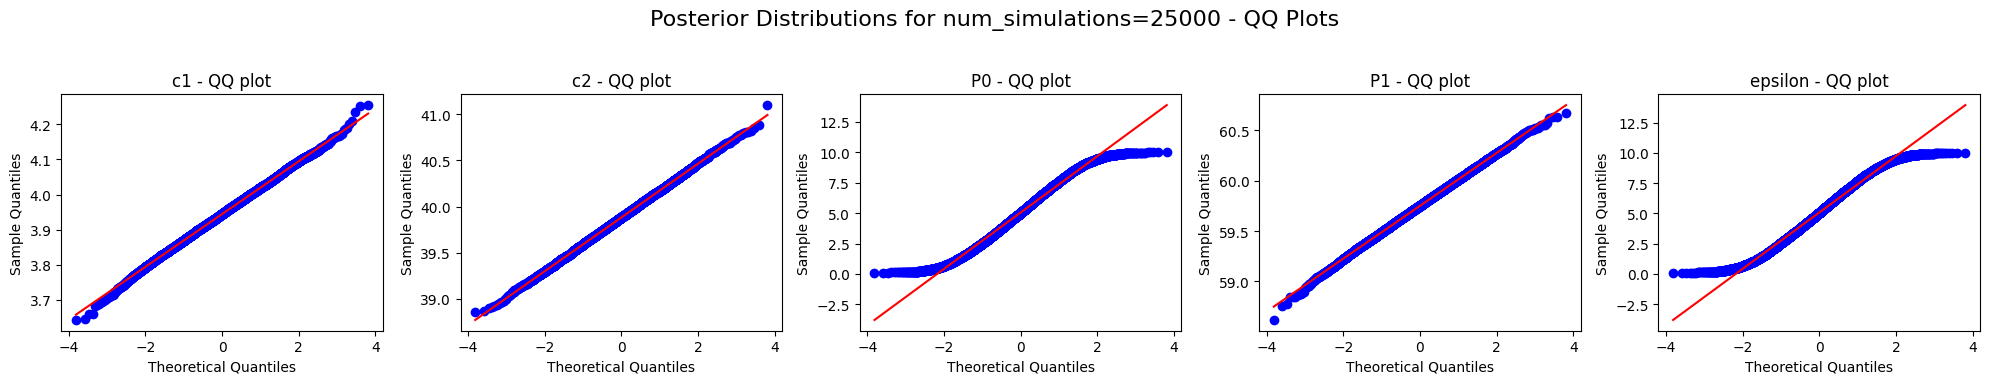

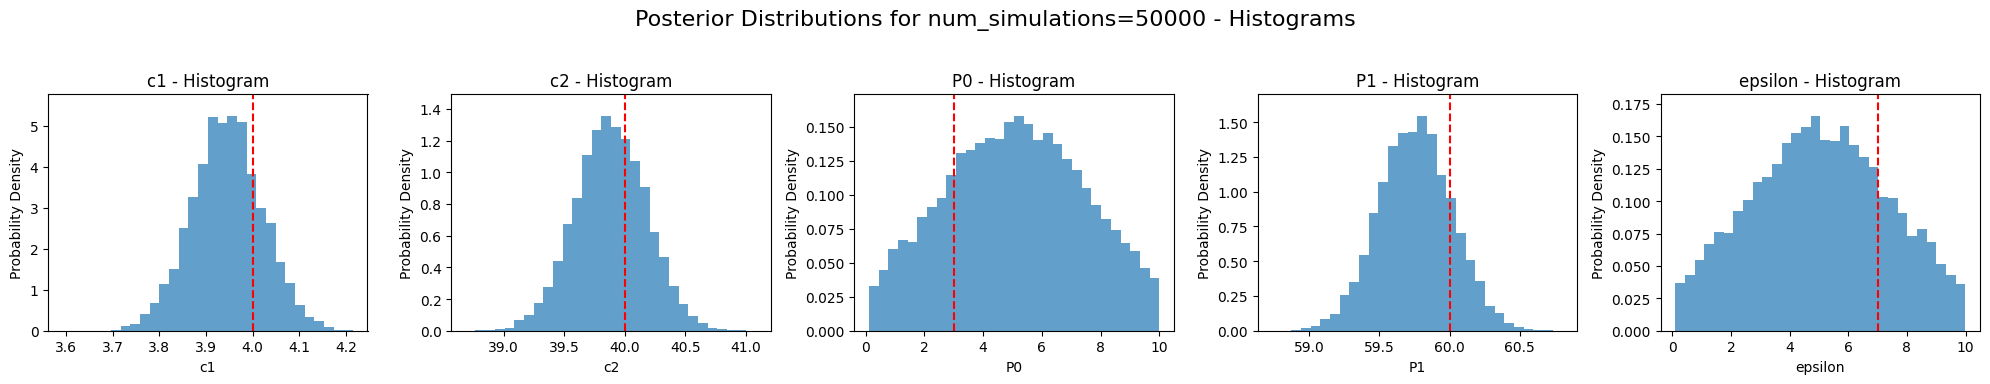

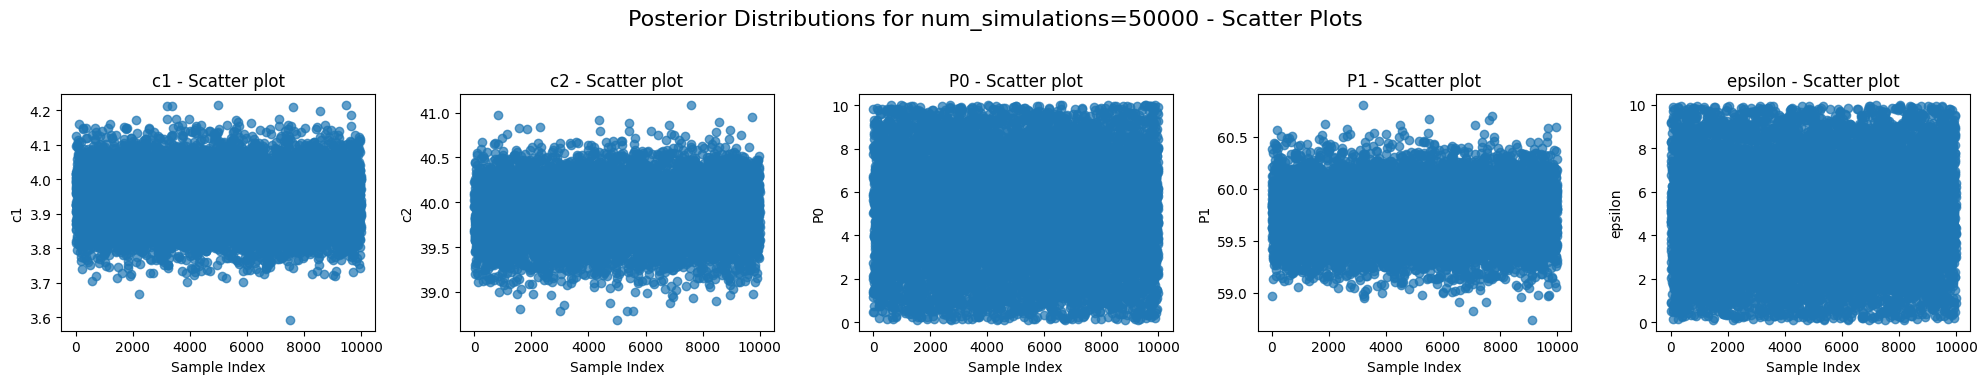

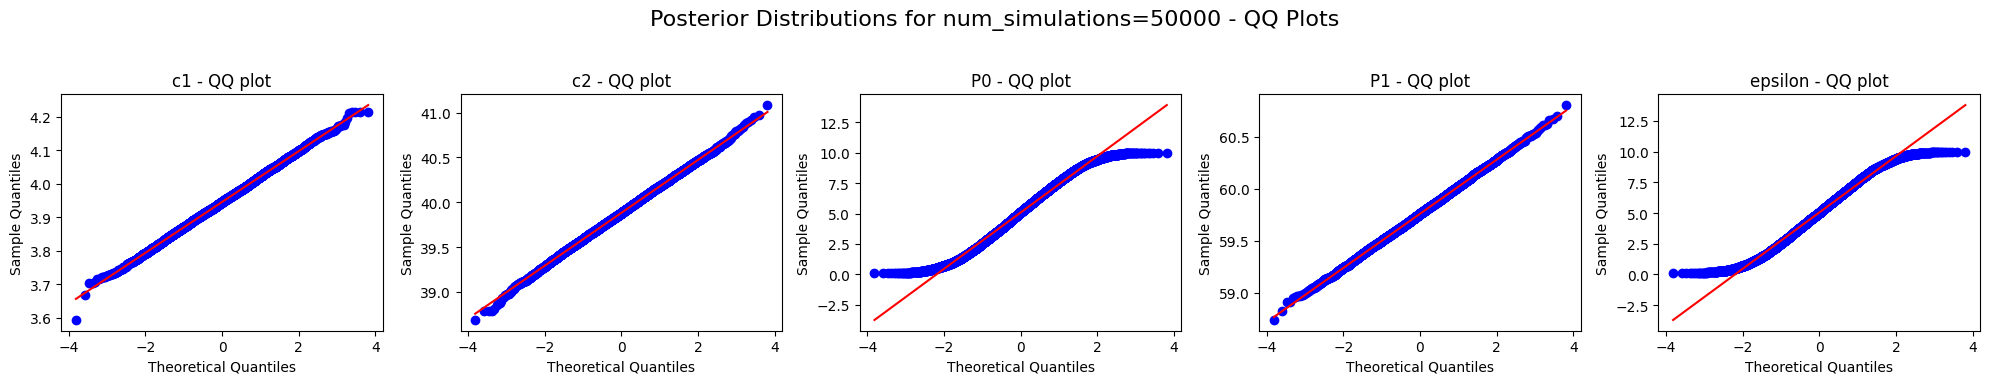

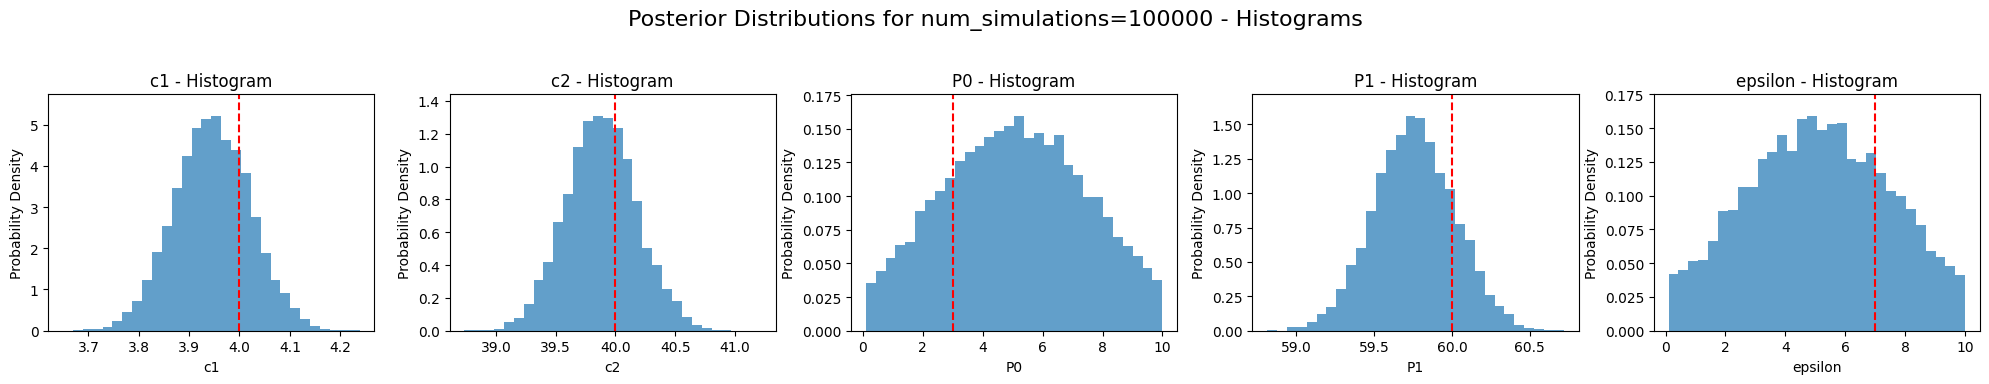

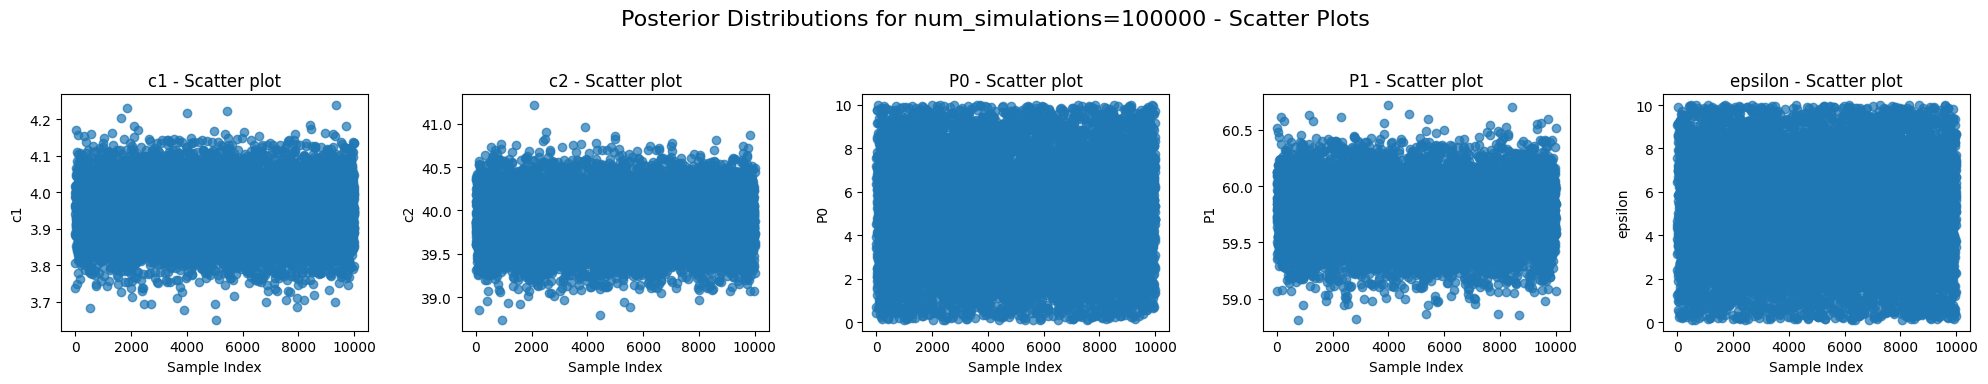

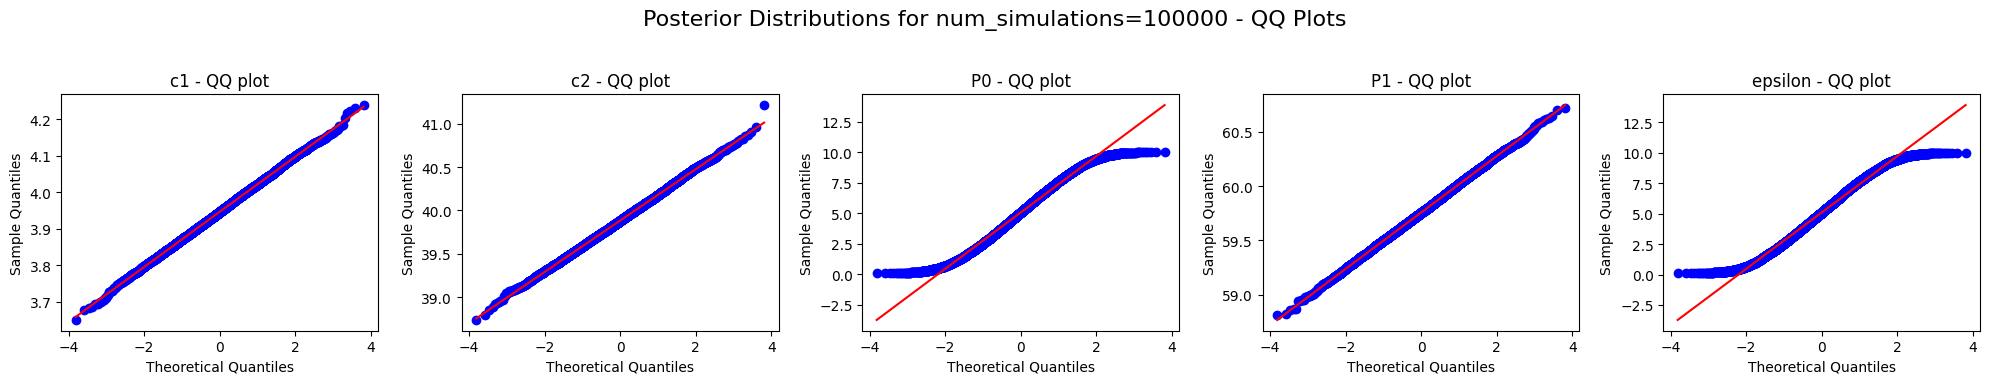

In [10]:
# Define the experimental setup variables
num_simulations = [100, 1000, 10000, 25000, 50000, 100000]

# Define the directory path
dir_path = '../../results/num_simulations/plots/'

# Create the directories
os.makedirs(dir_path, exist_ok=True)

# Plot settings
param_names = ['c1', 'c2', 'P0', 'P1', 'epsilon']

for i, num_sim in enumerate(num_simulations):
    
    # Extract posterior distributions for current num_simulations
    posterior_samples = posterior.sample((10000,), show_progress_bars=False)

    # Create separate figures for each type of plot
    fig1, axes1 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig2, axes2 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig3, axes3 = plt.subplots(1, len(param_names), figsize=(20, 4))

    # Plot each parameter for current num_simulations
    for j, param_name in enumerate(param_names):
        parameter_samples = posterior_samples[:, j]
        
        # Histogram
        counts, bins, _ = axes1[j].hist(parameter_samples, bins=30, density=True, alpha=0.7, label='Inferred')
        axes1[j].axvline(x=true_parameters[j], color='red', linestyle='--', label='True')
        axes1[j].set_title(param_name + ' - Histogram')
        axes1[j].set_ylabel('Probability Density')
        axes1[j].set_xlabel(param_name)
        
        # Scale the y-axis to span from 0% to 100%
        axes1[j].set_ylim(0, max(counts) * 1.1)  

        # Scatter plot
        axes2[j].scatter(range(len(parameter_samples)), parameter_samples, alpha=0.7)
        axes2[j].set_title(param_name + ' - Scatter plot')
        axes2[j].set_ylabel(param_name)
        axes2[j].set_xlabel('Sample Index')
        
        # QQ plot
        stats.probplot(parameter_samples, dist="norm", plot=axes3[j])
        axes3[j].set_title(param_name + ' - QQ plot')
        axes3[j].set_xlabel('Theoretical Quantiles')
        axes3[j].set_ylabel('Sample Quantiles')

    # Set titles for the figures
    fig1.suptitle(f'Posterior Distributions for num_simulations={num_sim} - Histograms', fontsize=16)
    fig2.suptitle(f'Posterior Distributions for num_simulations={num_sim} - Scatter Plots', fontsize=16)
    fig3.suptitle(f'Posterior Distributions for num_simulations={num_sim} - QQ Plots', fontsize=16)

    # Adjust layout and save the figures
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig1.savefig(os.path.join(dir_path, f'histogram_{num_sim}.pdf'))
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.savefig(os.path.join(dir_path, f'scatter_{num_sim}.pdf'))
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3.savefig(os.path.join(dir_path, f'qqplot_{num_sim}.pdf'))

    plt.show()

In [ ]:
# Initialize lists to store the results
medians = []
stds = []
kurtoses = []
skews = []

# Define the directory path
dir_path = '../../results/num_simulations/csv/'

# Create the directories
os.makedirs(dir_path, exist_ok=True)

# Calculate the statistics for each posterior
for i, posterior in enumerate(posteriors):
    samples = posterior.sample((10000,), show_progress_bars=False)
    samples_np = samples.numpy()
    median = np.median(samples_np, axis=0)
    std = np.std(samples_np, axis=0)
    kurt = kurtosis(samples_np, axis=0)
    skewness = skew(samples_np, axis=0)
    
    medians.append([num_simulations[i]] + list(median))
    stds.append([num_simulations[i]] + list(std)) 
    kurtoses.append([num_simulations[i]] + list(kurt))
    skews.append([num_simulations[i]] + list(skewness))

# Create a DataFrame for each statistic
df_medians = pd.DataFrame(medians, columns=['num_simulations'] + param_names)
df_medians.set_index('num_simulations', inplace=True)

df_stds = pd.DataFrame(stds, columns=['num_simulations'] + param_names)
df_stds.set_index('num_simulations', inplace=True)

df_kurtoses = pd.DataFrame(kurtoses, columns=['num_simulations'] + param_names)
df_kurtoses.set_index('num_simulations', inplace=True)

df_skews = pd.DataFrame(skews, columns=['num_simulations'] + param_names)
df_skews.set_index('num_simulations', inplace=True)

# Save the DataFrames as CSV files in the specified directory
df_medians.to_csv(os.path.join(dir_path, 'medians.csv'))
df_stds.to_csv(os.path.join(dir_path, 'standard_deviations.csv'))
df_kurtoses.to_csv(os.path.join(dir_path, 'kurtoses.csv'))
df_skews.to_csv(os.path.join(dir_path, 'skews.csv'))

# Print the tables
print("Medians:")
print(df_medians)
print("\nStandard Deviations:")
print(df_stds)
print("\nKurtoses:")
print(df_kurtoses)
print("\nSkews:")
print(df_skews)

Medians:
                       c1         c2        P0         P1   epsilon
num_simulations                                                    
100              4.199764  47.415474  4.534799  54.534035  5.593081
1000             5.110912  50.851791  4.987144  55.410912  5.074825
10000            5.001333  50.933773  4.710123  50.165512  5.204419
25000            5.020960  50.221718  4.851913  53.013618  5.126040
50000            4.183813  50.463989  5.048602  55.068382  4.953716
100000           4.148579  50.310387  4.916518  55.009319  5.081880

Standard Deviations:
                       c1         c2        P0         P1   epsilon
num_simulations                                                    
100              0.501082  22.979002  1.932169   6.646042  1.927135
1000             2.356962  23.151810  1.891925   6.966503  1.870745
10000            1.918327  23.327150  2.013072  10.696946  2.030454
25000            1.226480  23.193720  2.185854   8.013675  2.177679
50000            